# BLK 87/1

In [1]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("../data/CongoDB.sqlite")

## Keramik

In [7]:
sql = """SELECT
           t_Obj.objID,
           t_Ort.ort_kurz,
           t_Komplex.bef_nr, 
           t_Obj.Komplex, 
           t_Obj.Individuum,
           t_Obj.Anzahl,
           t_Obj.Typ, 
           t_Obj.Gewicht,
           t_Obj.Gr_Clist, 
           t_Obj.Art,
           t_Obj.Tiefe 
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_kurz) = 'BLK')
           AND ((t_Komplex.bef_nr) = '87/1'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['Tiefe'] = df['Tiefe'].convert_objects(convert_numeric=True)
display(df.head())

C:\Users\DirkSeidenticker\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,objID,ort_kurz,bef_nr,Komplex,Individuum,Anzahl,Typ,Gewicht,Gr_Clist,Art,Tiefe
0,1130,BLK,87/1,87/1-1-1,"-1,2:2",1,EPE,67,120,K,
1,1135,BLK,87/1,87/1-1-3,"3, -1-3-1:3",1,BOT (?),642,500,K,
2,1470,BLK,87/1,87/1-1-3,"2, -1:2",1,BOT (?),991,500,K,
3,1520,BLK,87/1,87/1-1-1,2,1,EPE/MKA (?),2000,500,K,
4,1526,BLK,87/1,87/1-1-3,"-1:4, -2:4",1,BOT (?),1997,500,K,


In [8]:
df_pivot = df.pivot_table(values = 'Gewicht', index = 'Komplex', columns = 'Art', aggfunc = sum)
df_pivot

Art,K,Metall,Stein
Komplex,,,
87/1-1-1,3268,NaN,NaN
87/1-1-2,86,252,653
87/1-1-3,4715,NaN,NaN


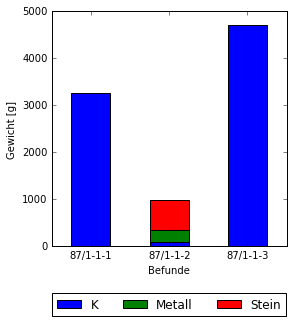

In [11]:
ax = df_pivot.plot(kind = 'bar', stacked=True)
plt.ylabel('Gewicht [g]')
plt.xlabel('Befunde')
plt.xticks(rotation=0)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.gca().set_aspect((abs(xlim[0]) + abs(xlim[1])) / (abs(ylim[0]) + abs(ylim[1])))
lgd = plt.legend(bbox_to_anchor=(0.5, -0.2), loc = 9, ncol=3, borderaxespad = 0.)
plt.tight_layout()
plt.savefig('../output/figs/9-11_BLK87-1_VerteilungFunde.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [5]:
# Generalisierung -- (?) weg
df['Type'] = df['Typ'].replace({'': '(?)', 'Botendo (?)': 'BOT', 'EPE (?)': 'EPE', 'EPE/MKA (?)': 'EPE'}, inplace=True)
# df['Type'] = df['Typ'].replace('Botendo (?)','BOT', inplace=True)

df_pivot = df.pivot_table(values = 'Anzahl', index = 'Komplex', columns = 'Typ', aggfunc = len, fill_value = 0, margins = True)
df_pivot.to_latex('../output/tabs/9-11_BLK87-1_VerteilungFunde.tex')
df_pivot

Typ,(?),BOT (?),EPE,All
Komplex,,,,
87/1-1-1,10,1,2,13
87/1-1-2,8,0,0,8
87/1-1-3,2,3,1,6
All,20,4,3,27


In [6]:
df_pivot1 = df.pivot_table(values = 'Gewicht', index = 'Art', aggfunc = sum, fill_value = 0)
df_pivot1 = pd.DataFrame(df_pivot1)
# df_pivot1 = df_pivot1.reset_index()
df_pivot1.rename(index={'HL': 'gebrannter Lehm', 'K': 'Keramik'}, inplace=True)
df_pivot1['\%'] = (df_pivot1['Gewicht']/df_pivot1['Gewicht'].sum()*100).round(1)
df_pivot1['Gewicht'] = (df_pivot1['Gewicht'] / 1000).round(2)
df_pivot1.rename(columns={'Gewicht': 'Gewicht (kg)'}, inplace=True)

df_pivot2 = df.pivot_table(values = 'Anzahl', index = 'Art', aggfunc = sum, fill_value = 0)
df_pivot2 = pd.DataFrame(df_pivot2)
df_pivot2.rename(index={'HL': 'gebrannter Lehm', 'K': 'Keramik'}, inplace=True)
df_pivot2['\%'] = (df_pivot2['Anzahl']/df_pivot2['Anzahl'].sum()*100).round(1)

# Tabellen vereinen:
df_concat = pd.concat([df_pivot2, df_pivot1], axis = 1)
df_concat = df_concat.reset_index()
df_concat.rename(columns={'Art': 'Fundkategorie'}, inplace=True)
df_concat.to_latex('../output/tabs/9-14_BLK87-1_Funde.tex', index = False, escape = False)
df_concat

,Fundkategorie,Anzahl,\%,Gewicht (kg),\%
0,Keramik,58,95.1,8.07,89.9
1,Metall,2,3.3,0.25,2.8
2,Stein,1,1.6,0.65,7.3


Gefäße *vs.* Einzelscherben:

In [6]:
# Gefäßscherben (Anzahl = 1)
sql = """SELECT
           t_Obj.objID,
           t_Obj.Anzahl,
           t_Obj.Gewicht,
           t_Obj.Art
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_kurz) = 'BLK')
           AND ((t_Komplex.bef_nr) = '87/1')
           AND ((t_Obj.Art) = 'K')
           AND ((t_Obj.Anzahl) = 1))""".replace('\n',' ')

df = pd.read_sql(sql, con)
a = df['Gewicht'].sum()
a

7783

In [7]:
# Gefäßscherben (Anzahl = 1)
sql = """SELECT
           t_Obj.objID,
           t_Obj.Anzahl,
           t_Obj.Gewicht,
           t_Obj.Art
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_kurz) = 'BLK')
           AND ((t_Komplex.bef_nr) = '87/1')
           AND ((t_Obj.Art) = 'K')
           AND ((t_Obj.Anzahl) != 1))""".replace('\n',' ')

df = pd.read_sql(sql, con)
b = df['Gewicht'].sum()
b

286

In [8]:
c = pd.Series({'Gefäße':a,
           'Scherben':b})
c

Gefäße      7783
Scherben     286
dtype: int64

In [9]:
fig = plt.figure(1)
fig.set_size_inches(5, 5)
# c.plot(kind='pie', autopct='%.0f %%', colors = ('dimgrey', 'lightgrey'))
# c.plot(kind='pie', autopct='%.0f %%', cmap = 'Paired')
c.plot(kind='pie', autopct='%.0f %%')
plt.savefig('../output/figs/9-11_BLK87-1_Keramik_A.pdf', bbox_inches='tight')
plt.show()

> **Abb. #** BLK 87/1: Zusammensetzung der Keramik (Gew.-%)

In [10]:
sql = """SELECT
           t_Obj.objID,
           t_Ort.ort_kurz,
           t_Komplex.bef_nr, 
           t_Obj.Komplex, 
           t_Obj.Individuum,
           t_Obj.Anzahl,
           t_Obj.Typ, 
           t_Obj.Gewicht,
           t_Obj.Gr_Clist, 
           t_Obj.Art,
           t_Obj.Scherbe 
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_kurz) = 'BLK')
           AND ((t_Komplex.bef_nr) = '87/1'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
display(df.head())

,objID,ort_kurz,bef_nr,Komplex,Individuum,Anzahl,Typ,Gewicht,Gr_Clist,Art,Scherbe
0,1130,BLK,87/1,87/1-1-1,"-1,2:2",1,EPE,67,120,K,R
1,1135,BLK,87/1,87/1-1-3,"3, -1-3-1:3",1,Botendo (?),642,500,K,R
2,1470,BLK,87/1,87/1-1-3,"2, -1:2",1,Botendo (?),991,500,K,G
3,1520,BLK,87/1,87/1-1-1,2,1,EPE/MKA (?),2000,500,K,G
4,1526,BLK,87/1,87/1-1-3,"-1:4, -2:4",1,Botendo (?),1997,500,K,G


In [11]:
df_pivot = df.pivot_table(values = 'Anzahl', index = 'Komplex', columns = 'Scherbe', aggfunc = sum, fill_value = 0, margins = True)
df_pivot

Scherbe,G,R,W,All
Komplex,,,,
87/1-1-1,1,3,27,31
87/1-1-2,0,1,9,13
87/1-1-3,2,2,13,17
All,3,6,49,61


## Fragmentierung

In [12]:
sql = """SELECT
           t_Obj.objID, 
           t_Obj.Gr_Clist, 
           t_Obj.Art
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_kurz) = 'MUN')
           AND ((t_Komplex.bef_nr) = '87/3')
           AND ((t_Obj.Art) = "K"))""".replace('\n',' ')

df = pd.read_sql(sql, con)
display(df.head())

,objID,Gr_Clist,Art
0,428,200,K
1,429,200,K
2,434,200,K
3,435,120,K
4,1106,120,K


In [13]:
df_pivot = df.pivot_table(values = 'objID', index = 'Gr_Clist', aggfunc = len)
# Dummy-Werte manuell:
df_pivot['>200'] = 0.
df_pivot = pd.DataFrame(df_pivot)
# Prozent-Anteil
df_pivot['Prozent'] = df_pivot['objID']/df_pivot['objID'].sum()*100
df_pivot

,objID,Prozent
Gr_Clist,,
30,8,28.571429
70,11,39.285714
120,6,21.428571
200,3,10.714286
>200,0,0.000000


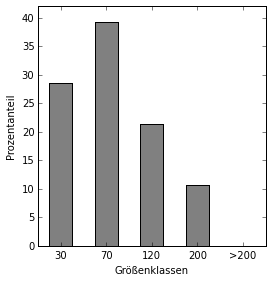

In [14]:
df_pivot['Prozent'].plot(kind = 'bar', color = 'gray')
plt.xticks(rotation=0)
plt.xlabel('Größenklassen')
plt.ylabel('Prozentanteil')
plt.ylim([0,42]) 
plt.gca().set_aspect(.125)
plt.tight_layout()
plt.savefig('../output/figs/9-11_BLK87-1_KeramikFragmentierung.pdf', bbox_inches='tight')
plt.show()